<a href="https://colab.research.google.com/github/EiffL/sbi_experiments/blob/main/notebooks/score_matching/DenseScoreMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating training by score matching

In this notebook, we just want to learn a score field when the score is known,
and using a simple neural network.

In [1]:
!pip install --quiet --upgrade dm-haiku optax tensorflow-probability

     |████████████████████████████████| 287 kB 12.1 MB/s 
     |████████████████████████████████| 126 kB 48.5 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [3]:
d=2

In [4]:
@jax.jit
def get_two_moons(sigma, resolution=1024):
    """
    Returns two moons distribution as a TFP distribution
    Parameters
    ----------
    sigma: float
    Spread of the 2 moons distribution.
    resolution: int
    Number of components in the gaussian mixture approximation of the
    distribution (default: 1024)
    Returns
    -------
    distribution: TFP distribution
    Two moon distribution
    """

    outer_circ_x = np.cos(np.linspace(0, np.pi, resolution))
    outer_circ_y = np.sin(np.linspace(0, np.pi, resolution))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, resolution))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, resolution)) - .5

    X = np.append(outer_circ_x, inner_circ_x)
    Y = np.append(outer_circ_y, inner_circ_y)
    coords = np.vstack([X,Y]).astype('float32')

    distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution).astype('float32')/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma)
    )

    return distribution

## First experiment: Train a NN directly for the score

In [5]:
class NeuralScoreModel(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x):
    net = hk.Linear(128)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(2)(net)
    return net

In [7]:
model = hk.without_apply_rng(hk.transform(lambda x : NeuralScoreModel()(x)))

rng_seq = hk.PRNGSequence(12)
params = model.init(next(rng_seq), jnp.zeros([1,d]))

In [12]:
@jax.jit
def loss_fn(params, batch, score):
  out = model.apply(params, batch)
  return jnp.mean( jnp.sum((out - score)**2, axis=1))

@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [14]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)

In [15]:
batch_size=1024

@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma= 0.05)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)

  return batch, score

losses = []
it = 4000

opt_state = optimizer.init(params)
master_seed = hk.PRNGSequence(0)

for step in tqdm(range(it)):
  batch, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, batch, score)
  losses.append(l)

100%|██████████| 4000/4000 [00:17<00:00, 226.44it/s]


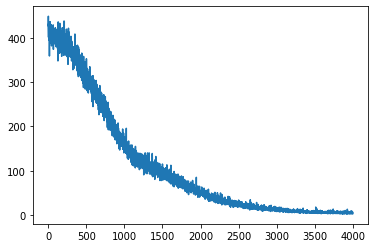

In [16]:
plot(losses)

In [36]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

# Getting value of the log prob and score for the true distribution
logp = get_two_moons(sigma=0.05).prob(points).reshape([len(Y), len(X)])
true_score = jax.vmap(jax.grad(lambda x: get_two_moons(sigma=0.05).log_prob(x)))(points).reshape([len(Y), len(X), 2])

# Getting value of the score as predicted by the NN
pred_score = model.apply(params, points).reshape([len(Y), len(X),2])

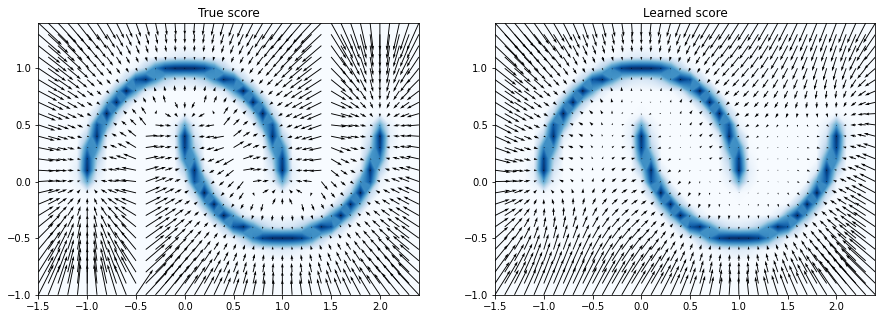

In [45]:
figure(figsize=[15,5])
subplot(121)
contourf(X,Y,logp, 256, cmap='Blues')
quiver(X, Y, true_score[:,:,0], true_score[:,:,1], scale=5000);
title('True score')

subplot(122)
contourf(X,Y,logp, 256, cmap='Blues')
quiver(X, Y, pred_score[:,:,0], pred_score[:,:,1], scale=5000);
title('Learned score');

## Second experiment: Train the grad of a NN for the score

In [48]:
class NeuralScoreModel(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x):
    net = hk.Linear(128)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(1)(net)
    return net

In [49]:
model = hk.without_apply_rng(hk.transform(lambda x : NeuralScoreModel()(x)))

rng_seq = hk.PRNGSequence(12)
params = model.init(next(rng_seq), jnp.zeros([1,d]))

In [53]:
@jax.jit
def loss_fn(params, batch, score):
  out = jax.vmap(jax.grad(lambda x: model.apply(params, x).squeeze()))(batch) # Here we extract the grad of the model
  return jnp.mean( jnp.sum((out - score)**2, axis=1))

@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [54]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)

In [55]:
batch_size=1024

@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma= 0.05)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)

  return batch, score

losses = []
it = 4000

opt_state = optimizer.init(params)
master_seed = hk.PRNGSequence(0)

for step in tqdm(range(it)):
  batch, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, batch, score)
  losses.append(l)

100%|██████████| 4000/4000 [00:15<00:00, 256.38it/s]


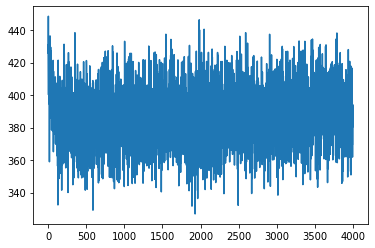

In [56]:
plot(losses)

In [59]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

# Getting value of the log prob and score for the true distribution
logp = get_two_moons(sigma=0.05).prob(points).reshape([len(Y), len(X)])
true_score = jax.vmap(jax.grad(lambda x: get_two_moons(sigma=0.05).log_prob(x)))(points).reshape([len(Y), len(X), 2])

# Getting value of the score as predicted by the NN
pred_fn = model.apply(params, points).reshape([len(Y), len(X)])
pred_score = jax.vmap(jax.grad(lambda x: model.apply(params, x).squeeze()))(points).reshape([len(Y), len(X),2])

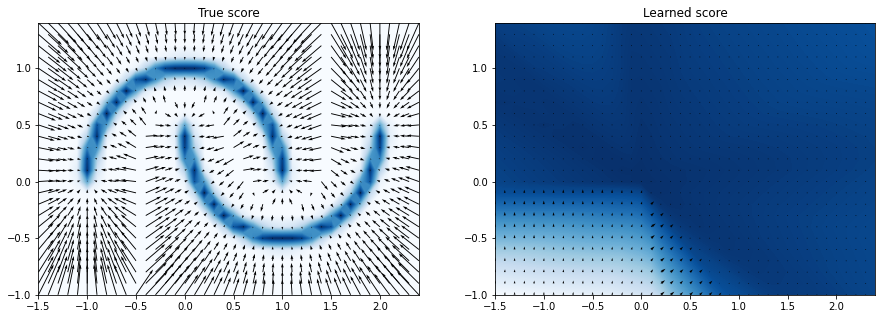

In [61]:
figure(figsize=[15,5])
subplot(121)
contourf(X,Y,logp, 256, cmap='Blues')
quiver(X, Y, true_score[:,:,0], true_score[:,:,1], scale=5000);
title('True score')

subplot(122)
contourf(X,Y,pred_fn, 256, cmap='Blues')
quiver(X, Y, pred_score[:,:,0], pred_score[:,:,1], scale=5000);
title('Learned score');

## Third Experiment: Using a $C^{\infty}$ class network

In [75]:
class NeuralScoreModel(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x):
    net = hk.Linear(128)(x)
    net = jnp.sin(net)
    net = hk.Linear(128)(net)
    net = jnp.sin(net)
    net = hk.Linear(1)(net)
    return net

In [76]:
model = hk.without_apply_rng(hk.transform(lambda x : NeuralScoreModel()(x)))

rng_seq = hk.PRNGSequence(12)
params = model.init(next(rng_seq), jnp.zeros([1,d]))

In [77]:
@jax.jit
def loss_fn(params, batch, score):
  out = jax.vmap(jax.grad(lambda x: model.apply(params, x).squeeze()))(batch) # Here we extract the grad of the model
  return jnp.mean( jnp.sum((out - score)**2, axis=1))

@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [78]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)

In [79]:
batch_size=1024

@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma= 0.05)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)

  return batch, score

losses = []
it = 4000

opt_state = optimizer.init(params)
master_seed = hk.PRNGSequence(0)

for step in tqdm(range(it)):
  batch, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, batch, score)
  losses.append(l)

100%|██████████| 4000/4000 [00:16<00:00, 241.47it/s]


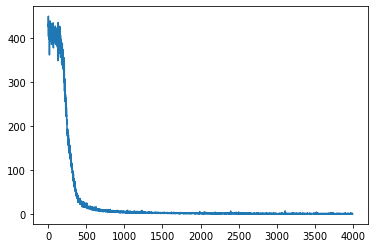

In [80]:
plot(losses)

In [81]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

# Getting value of the log prob and score for the true distribution
logp = get_two_moons(sigma=0.05).prob(points).reshape([len(Y), len(X)])
true_score = jax.vmap(jax.grad(lambda x: get_two_moons(sigma=0.05).log_prob(x)))(points).reshape([len(Y), len(X), 2])

# Getting value of the score as predicted by the NN
pred_fn = model.apply(params, points).reshape([len(Y), len(X)])
pred_score = jax.vmap(jax.grad(lambda x: model.apply(params, x).squeeze()))(points).reshape([len(Y), len(X),2])

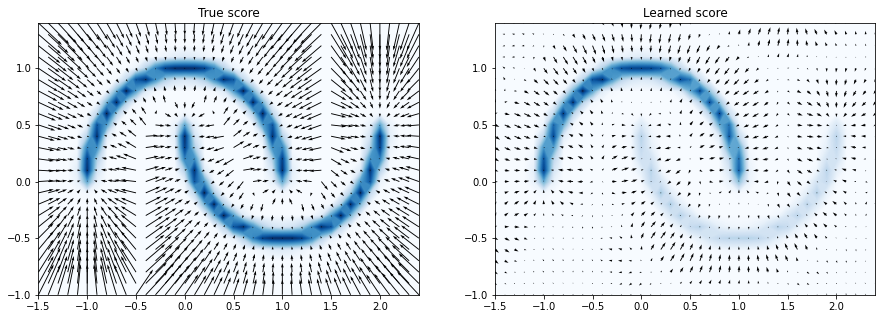

In [83]:
figure(figsize=[15,5])
subplot(121)
contourf(X,Y,logp, 256, cmap='Blues')
quiver(X, Y, true_score[:,:,0], true_score[:,:,1], scale=5000);
title('True score')

subplot(122)
contourf(X,Y,exp(pred_fn), 256, cmap='Blues')
quiver(X, Y, pred_score[:,:,0], pred_score[:,:,1], scale=5000);
title('Learned score');